In [1]:
D.<x> = PolynomialRing(QQ)
R = PolynomialRing(QQ,'x')
S = PowerSeriesRing(QQ,'x', default_prec=300)
L=LaurentSeriesRing(QQ,'x', default_prec=300)
#S.<x,y>=PowerSeriesRing(QQ,default_prec=300)
# Using "R = PolynomialRing(QQ,'x')" produces an error.
# Yet using S as defined here is fine (see definition of Fraleigh4 below)
# But S = PowerSeriesRing(QQ,'x','y') also produces an error.
Scplx= PowerSeriesRing(CC,'x',default_prec=300)
def pochhammer(x,n):
    return product ([x+k for k in [0..n-1]])
def cRaleigh2(alpha,beta,nu):
    pchhmrA = pochhammer(alpha,nu)
    pchhmrB = pochhammer(beta,nu)
    fnu=factorial(nu)
    answer = D(pchhmrA*pchhmrB/fnu^2)
    return answer
def term(alpha,beta,p):
    return D(1/(alpha + p) + 1/(beta + p) - 2/(1 + p))
def eRaleigh(alpha, beta, nu):
    return D(sum([term(alpha, beta, p) for p in [0..nu - 1]]))
def FstarRaleigh2(alpha,beta,u,terms):
    fsr = sum([cRaleigh2(alpha, beta, nu)*eRaleigh(alpha,beta,nu)*u^nu for nu in [1..terms]])
    return D(fsr)
def Fraleigh2(alpha,beta,u,terms): 
    return D(sum([cRaleigh2(alpha,beta,nu)*u^nu for nu in [0..terms]]))
def FstarRaleigh3(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fsr2 = FstarRaleigh2(alpha,beta,x,n)
    return D(fsr2)
def Fraleigh4(n,m,x):
    alpha = (1/2-1/m)/2
    beta = (1/2+1/m)/2
    fr2 = Fraleigh2(alpha,beta,x,n)
    return D(fr2)
def exNo3c(n,m):
    a1 = S(x)*exp(S(FstarRaleigh3(n,m,x)/Fraleigh4(n,m,x))).O(2*n)
    # S(x) instead of x in df of a1 to avoid an error message
    # after use of the stripQuotationMarks command below.
    a2 = S(a1).O(n+1)
    return a2 # applying S to argument of exp is key.
def J(n,m):
    exn = exNo3c(n+2,m)
    jnm = 1/exn.reverse()
    return jnm.O(n+1) # Jtest is faster than J, and they agree.
def normalJ(n,m):
    f = J(n,m)
    return f.truncate(n+1)
def Jcoefficient(n,m):
    f = J(n+2,m)
    f1 = f.truncate(n+1)
    f1=f1.list()
    f1=Set(f1)
    g1 = f.truncate(n)
    g1 = g1.list()
    g1 = set(g1)
    h = f1.difference(g1)
    h = h.list()
    return h[0]
def xjNewStep(n,m): 
    f=J(n,m)
    fl=f.list()
    return (sum(c*x**i*(m**3*2**6)**i for i,c in enumerate(fl)))
def xjNew(n,m):
    return xjNewStep(n-1,m)
def xjNewCoefficient(n,m):
    if n>0:return (xjNew(n,m)-xjNew(n-1,m))/x^n
    if n==0:return 1
def xjNewTest(n,m):
    return D(xjNewStep(n-1,m))
def j(n,m):return xjNew(n,m)/x

def H4(n,m): # this is the definition in the published interpolations paper (2021):
    # def. 8.4
    jay=J(n+1,m)
    djay=x*derivative(jay,x) # bc variable is tau, not x; chain rule.
    numerator = djay^2
    denominator = jay*(jay-1)
    return ((S(numerator/denominator)^(1/(m-2))).O(n+1)).polynomial()
    #if argument is an S type then 'polynomial' takes no argument.

def H4strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H4(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer


def H6(n,m):
    def base6(n,m):
        jay=J(n+1,m)
        num=(x*derivative(jay,x))^m # chain rule; variable is tau not x.
        den = expand(jay^(m-1)*(jay-1))
        return L((-1)^m*(num/den)).O(n+1)
    return S(base6(n,m)^(1/(m-2))).polynomial()
     #if argument is an S type then 'polynomial' takes no argument.

def H6strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=H6(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [0..polydegree])
    return answer

def polynomialCoefficient(n,poly):
    return poly.list()[n]
def factorpairToFactor(factorpair):
    (monomial,exponent)=factorpair
    return monomial^exponent
def numericalfactor(polynomial):
    fp=polynomial.factor()
    lst=[factorpairToFactor(factorpair) for factorpair in fp]
    return polynomial/product(lst)
def lastfactor(polynomial):
    fp=polynomial.factor()
    fp=FiniteEnumeratedSet(fp)
    return factorpairToFactor(fp.last())
def reduced(polynomial):
    return numericalfactor(polynomial)*lastfactor(polynomial)
def stripQuotationMarks(string):
    var('x')
    return sage_eval(string,locals={'x':x})
def nieburTau(n):
# The contortions below sidestep mysterious (to me) error messages...
# nieburTau is an algorith for Ramanujan''s tau from the paper
# "A formula for Ramanujan's tau-function" by Douglas Niebur.
# (He spells tau with the Greek letter.)
    def step1(n,k):
        return 35*k^4-52*k^3*n+18*k^2*n^2
    def step2(n,k):
        return sigma(k)*sigma(n-k)
    def step3(n):
        ans=0
        for k in [1..n-1]:
            ans=ans+step1(n,k)*step2(n,k)
        return 24*ans
    return n^4*sigma(n)-step3(n)

def deltaDagger(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return ((ddstep1(n,m)-ddstep2(n,m))/1728)

def deltaDaggerStrike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def deltaDagger2(n,m):
    def ddstep1(n,m):
        return D(S(expand((H4(n+2,m)^3)))).truncate(n+1)
    def ddstep2(n,m):
        return D(S((H6(n+2,m)^2))).truncate(n+1)
    return (ddstep1(n,m)-ddstep2(n,m))

# def deltaDaggerStrike(n,m):
 #   return S(((H4strike(n,3)^3-H6strike(n,3)^2)/1728)).truncate(n+1)
    
def deltaDagger2Strike(n,m): #this applies the strike operator to the version of H4 that *is*
    #in the Integers paper.
    poly=deltaDagger2(n,m)
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    return answer

def first(list):return list[0]
def last(list):return list[-1]

def rmnjntau(n):
    answer=0
    for k in [1..n-1]:
        answer=answer+(6*k-4*(n-k))*sigma(k,3)*sigma(n-k,5)
    answer=(5*sigma(n,3)+7*sigma(n,5))*n/12-35*answer
    return answer

def element(k,listo):
    if k>len(listo):return (print("bad k"))
    return listo[k-1]

def mobiusInverseOfFunction(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        f=f+moebius(dvk)*g(n/dvk)
    return f

def mobiusInverseOfList(g,n):
    dv=divisors(n)
    nd=len(dv)
    f=0
    for k in [1..nd]:
        dvk=element(k,dv)
        gndvk=element(n/dvk,g)
        f=f+moebius(dvk)*gndvk
    return f

def drop_first_element(listo):
    lenth=len(listo)
    answer=[]
    for k in [1..lenth-1]:
        answer=answer+[listo[k]]
    return answer

def factorSeriesFromLists(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
    return nswr

def factorSeriesFromListsWithTracking(lsst,bound):
    truncatedlist=drop_first_element(lsst)
    F=[element(1,truncatedlist)]
    nswr=[-mobiusInverseOfList(F,1)/1]
    for n in [2..bound]:
        summ=0
        for k in [1..n-1]:
            ekf=element(k,F)
            tnk=element(n-k,truncatedlist)
            summ=summ+ekf*tnk
            print((n,k))
        Fn=n*element(n,truncatedlist)-summ
        F=F+[Fn]
        xpn=-mobiusInverseOfList(F,n)/n
        nswr=nswr+[xpn]
        print("answer length: ",len(nswr))
    return nswr



print("ok")

ok


In [ ]:
#from 'H4 from scratch per 2021 Integers paper'
data=[]
import time
for m in [3..403]:
    start=time.time()
    poly=H4(100,m)
    data=data+[[m,poly]]
    finish=time.time()
    print([m,poly.degree(),finish-start])
import pickle
wfile = open('/Users/barrybrent/21mar12no15.txt','w') # H4 series (date typo)
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [ ]:
data=[]
for m in [3..400]:
    if 10 in divisors(m):
        print m
    data=data+[[m,H6(100,m)]] # this is okay; all m are included.
import pickle
wfile = open('/Users/barrybrent/8mar21no13.txt','a') #H6 series from 'H6 from scratch'
s = pickle.dumps(str(data))
wfile.write(s)
wfile.close()

In [11]:
for m in [3..5]:
    print("-----------------------------------------------------------------------")
    print("m: ",m)
    print(deltaDagger2Strike(5,m)/1728)

-----------------------------------------------------------------------
m:  3
4830*x^5 - 1472*x^4 + 252*x^3 - 24*x^2 + x
-----------------------------------------------------------------------
m:  4
-11033903104/9*x^5 - 466313216/27*x^4 - 894976/9*x^3 - 15200/27*x^2 + 58/27*x
-----------------------------------------------------------------------
m:  5
-5193731694125/81*x^5 - 52964129375/162*x^4 - 66973250/81*x^3 - 159125/54*x^2 + 215/54*x


In [12]:
import pickle
rfile = open('/Users/barrybrent/21mar12no15.txt','rb') # H4 series (date typo)
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)

import pickle
rfile2 = open('/Users/barrybrent/8mar21no13.txt','rb') #H6 series from 'H6 from scratch'
rt=pickle.load(rfile2)
t=stripQuotationMarks(rt)
rfile2.close()

import pickle
import time
wfile = open('/Users/barrybrent/11sept22no1.txt','wb') # deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..3]:
    start = time.time()
    m=s[n][0]
    h6squared=t[n][1]^2
    h4cubed=s[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(10)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    data=data+[[m,answer]]
    finish = time.time()
    print([m,finish-start])
    print(answer)
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

[3, 0.010865926742553711]
-26976156429147240100640897969141317632*x^9 + 11605064230210968309415347581091840*x^8 - 1331095209573576294170345078784*x^7 - 278238965211867954467045376*x^6 + 128590699746675728056320*x^5 - 22679135757791133696*x^4 + 2246857312960512*x^3 - 123834728448*x^2 + 2985984*x
[4, 0.012289047241210938]
-2926432772461416669756567594331406994937700778246144*x^9 - 22257785230271588502400394155209315632820518912*x^8 - 113459910957209902850354937099644582232064*x^7 - 676354977751771797168565995228364800*x^6 - 2442475040323169116442767392768*x^5 - 8400352103262150453100544*x^4 - 11808438222965440512*x^3 - 16320875724800*x^2 + 15204352*x
[5, 0.02189469337463379]
-2463443879654269929478160384000000000000000000000000000000000/567*x^9 - 284750010926570039725260800000000000000000000000000000/63*x^8 - 48919745441277830758400000000000000000000000000/9*x^7 - 40705514928670244864000000000000000000000/9*x^6 - 10892044809797632000000000000000000/3*x^5 - 6942114365440000000000000000/3*

In [13]:
import pickle
rfile = open('/Users/barrybrent/21mar12no15.txt','rb') # H4 series (date typo)
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)

import pickle
rfile2 = open('/Users/barrybrent/8mar21no13.txt','rb') #H6 series from 'H6 from scratch'
rt=pickle.load(rfile2)
t=stripQuotationMarks(rt)
rfile2.close()

print(len(s),len(t))

401 118


In [18]:
import pickle
rfile = open('/Users/barrybrent/21mar12no15.txt','rb') # H4 series (date typo)
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)

import pickle
rfile2 = open('/Users/barrybrent/8mar21no13.txt','rb') #H6 series from 'H6 from scratch'
rt=pickle.load(rfile2)
t=stripQuotationMarks(rt)
rfile2.close()

import pickle
import time
wfile = open('/Users/barrybrent/11sept22no2.txt','wb') # deltaDagger2Strike series
data=[]
start = time.time()
for n in [0..117]:
    start = time.time()
    m=s[n][0]
    h6squared=t[n][1]^2
    h4cubed=s[n][1]^3
    dagger=D((h4cubed-h6squared)).truncate(100)
    poly=dagger
    polylist=poly.list()
    polydegree=poly.degree()
    answer=sum(polylist[k]*(x*m^3*2^6)^k for k in [1..polydegree])
    data=data+[[m,answer]]
    finish = time.time()
    print([m,finish-start])
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

[3, 0.012328863143920898]
[4, 0.01386713981628418]
[5, 0.023910045623779297]
[6, 0.010762929916381836]
[7, 0.024070262908935547]
[8, 0.024055004119873047]
[9, 0.024585962295532227]
[10, 0.024424076080322266]
[11, 0.024937152862548828]
[12, 0.023981094360351562]
[13, 0.025897979736328125]
[14, 0.02580881118774414]
[15, 0.02691507339477539]
[16, 0.025201082229614258]
[17, 0.025829792022705078]
[18, 0.02643108367919922]
[19, 0.02556777000427246]
[20, 0.024813175201416016]
[21, 0.02506279945373535]
[22, 0.025814056396484375]
[23, 0.027252912521362305]
[24, 0.026988983154296875]
[25, 0.025669097900390625]
[26, 0.026053190231323242]
[27, 0.025590896606445312]
[28, 0.02524280548095703]
[29, 0.026958703994750977]
[30, 0.02525806427001953]
[31, 0.025141000747680664]
[32, 0.02585911750793457]
[33, 0.028229236602783203]
[34, 0.027820825576782227]
[35, 0.025670766830444336]
[36, 0.025771141052246094]
[37, 0.026173830032348633]
[38, 0.027836084365844727]
[39, 0.025283098220825195]
[40, 0.0264031887

In [19]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/11sept22no2.txt','rb') # deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
bound=99
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
dfeg=drop_first_element(g(0))
print("dfeg:");print(dfeg)
fs=factorSeriesFromLists(dfeg,bound-1)
print([m(0),fs])
print(len(fs))

dfeg:
[2985984, -123834728448, 2246857312960512, -22679135757791133696, 128590699746675728056320, -278238965211867954467045376, -1331095209573576294170345078784, 11605064230210968309415347581091840, -26976156429147240100640897969141317632, -47548792446916577960998513928558597898240, 378933987989529921643011242658999788416008192, -454335787090604003604141397166249972437050458112, -1222765756034866657612963241534324192123462690537472, 1469692673453279280522734257815740070838929814708027392, 7692145346289317095905141453983304186144675737902629519360, 10780044136368626542372199062032671462067947654601952217530368, -130319591527289667625214372033584507516828854414527276562908184576, 88937507967179624889645010787730722557404277663309216841786871250944, 600744516475139429090652798550742428185926103723866730416639508920401920, -692266700703002833312828409319742639178151289149661883428926723552738017280, -709940570557472540431145489404636242557516960323082816383251322338397485268992, -373040446

In [21]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/11sept22no2.txt','rb') # deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
bound=100
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
dfeg=drop_first_element(g(0))
fs=factorSeriesFromLists(dfeg,bound-1)
print([m(0),fs])
print(len(fs))

bad k


TypeError: unsupported operand parent(s) for *: 'Integer Ring' and '<class 'NoneType'>'

In [22]:
import pickle
rfile = open('/Users/barrybrent/11sept22no2.txt','rb') # deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
print(len(s))

118


In [2]:
R.<x> = PowerSeriesRing(ZZ)
import pickle
rfile = open('/Users/barrybrent/11sept22no2.txt','rb') # deltaDagger2Strike series
rs=pickle.load(rfile) 
rfile.close()
s=stripQuotationMarks(rs)
data=[]
bound=99
def m(n):return s[n][0]
def pre_g(n):return s[n][1]
def g(n):return list(D(pre_g(n)))
for index in [0..117]:
    print(index)
    dfeg=drop_first_element(g(index))
    fs=factorSeriesFromLists(dfeg,bound-1)
    data=data+[[m(index),fs]]

wfile = open('/Users/barrybrent/12sept22no1.txt','wb') #deltaDagger2 exponents
t = pickle.dumps(str(data))
wfile.write(t)
wfile.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [44]:
import pickle
rfile = open('/Users/barrybrent/12sept22no1.txt','rb') #deltaDagger2 exponents
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
polydata=[]
import time
start = time.time()
for qpower in [1..5]: 
    data=[]
    for k in [0..len(s)-1]:
        m = s[k][0]
        poly=D(s[k][1])
        cf=QQ(polynomialCoefficient(qpower,poly))
        print("cf type: ",type(cf))
        print((qpower,m,cf))
        data=data+[[m,cf]]
    print(len(data))
    rl=R.lagrange_polynomial(data)

cf type:  <class 'sage.rings.rational.Rational'>
(1, 3, 7667517737975719919616)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 4, 133185504020613025195098112)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 5, 159304485010578967168000000000/3)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 6, 5717317305047380228853244887040)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 7, 277423700012747778946166903406592)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 8, 23207648111649405307242731723030528/3)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 9, 142913837134432756895844514198781952)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 10, 1918331131172512953601622016000000000)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 11, 19942892727839097167119541803167252480)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 12, 168164983105589642251880334895047770112)
cf type:  <class 'sage.rings.rational.Rational'>
(1, 13, 1190671321452777574595730638

(3, 117, 91975510898855118344867718900152128279154666583814604352307533565981448258532240729326244883000283549292600385314483823706112/5)
cf type:  <class 'sage.rings.rational.Rational'>
(3, 118, 83089833138864909359220338418851180976933577668788570519088377193062188006705166443131517821189904370740794443209263554756608/3)
cf type:  <class 'sage.rings.rational.Rational'>
(3, 119, 41557426179559752745912773187090715434603680223525917185696443632085258366783131560882339635165802977647875744952261709660160)
cf type:  <class 'sage.rings.rational.Rational'>
(3, 120, 62143172938907915921250074313449878650375887956437894789688638945806645402169506928078561446159977618569034727424000000000000)
118
cf type:  <class 'sage.rings.rational.Rational'>
(4, 3, 5824276149196696126593107169728136631314845954432040960)
cf type:  <class 'sage.rings.rational.Rational'>
(4, 4, 231604706868478492884205393072869890348728487581718017380574035968)
cf type:  <class 'sage.rings.rational.Rational'>
(4, 5, 66162874

In [45]:
# interpolating polynomials
import pickle
rfile = open('/Users/barrybrent/12sept22no1.txt','rb') #deltaDagger2 exponents
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
polydata=[]
import time
wfile = open('/Users/barrybrent/12sept22no2.txt','wb') ##deltaDagger2 exponents polynomials
start = time.time()
for qpower in [1..5]: 
    data=[]
    for k in [0..len(s)-1]:
        m = s[k][0]
        poly=D(s[k][1])
        cf=polynomialCoefficient(qpower,poly)
        data=data+[[m,cf]]
    rl=R.lagrange_polynomial(data)
    polydata=polydata+[[qpower,rl]] 
    rl=D(rl)
    finish = time.time()
    print([qpower,rl.degree(),finish-start])
t = pickle.dumps(str(polydata))
wfile.write(t)
wfile.close()

[1, 24, 0.055236101150512695]
[2, 36, 0.10946011543273926]
[3, 48, 0.16595005989074707]
[4, 60, 0.22268319129943848]
[5, 72, 0.3300142288208008]


exponent:  99
j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136


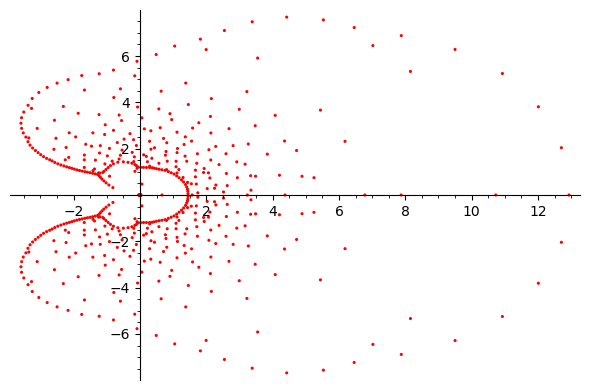

In [5]:
import pickle
rfile = open('/Users/barrybrent/9sept22no4.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [99..99]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        print("j: ",j)
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)

exponent:  50
j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136


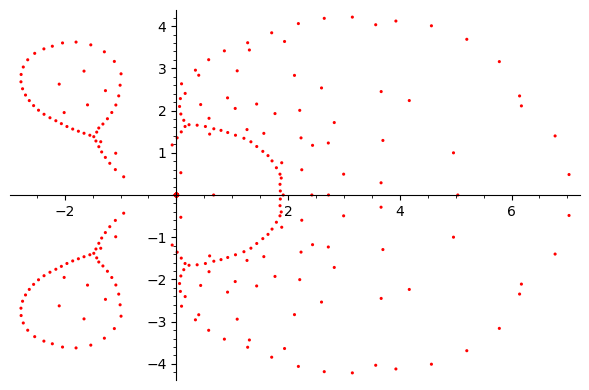

In [6]:
import pickle
rfile = open('/Users/barrybrent/9sept22no4.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
for k in [50..50]:
    print("=====================================================================================")
    print("exponent: ",s[k][0])
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        print("j: ",j)
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        roots=roots+[rootpair]
       
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)

exponent:  0


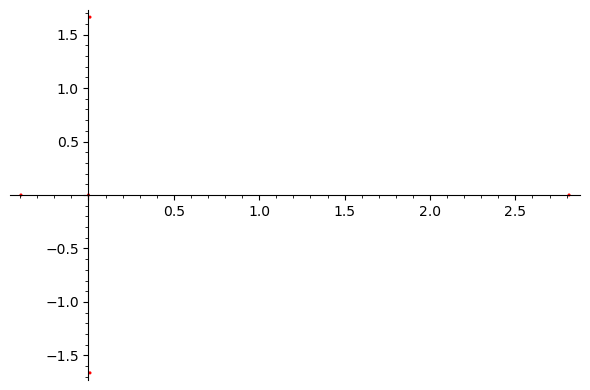

exponent:  1


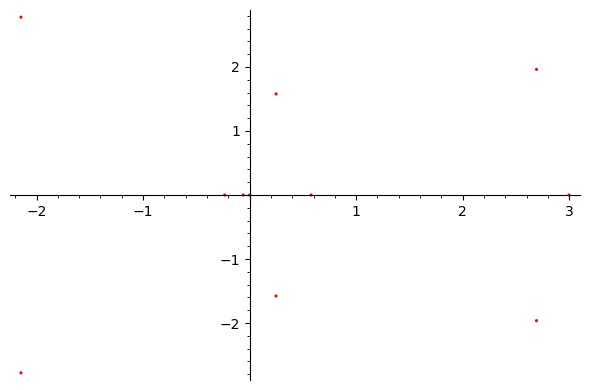

exponent:  2


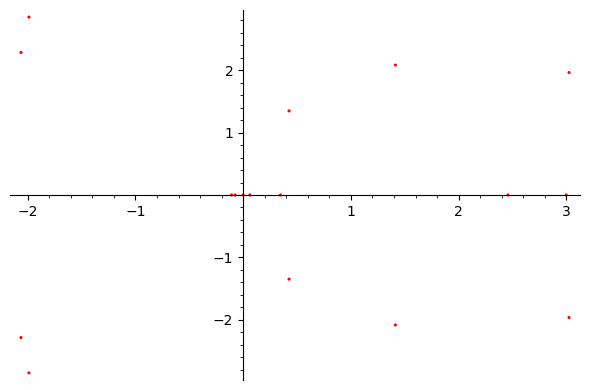

exponent:  3


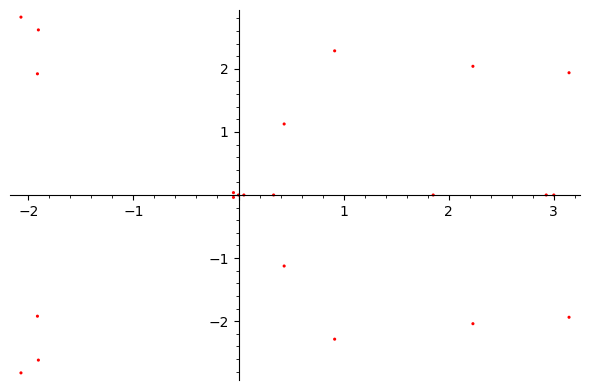

exponent:  4


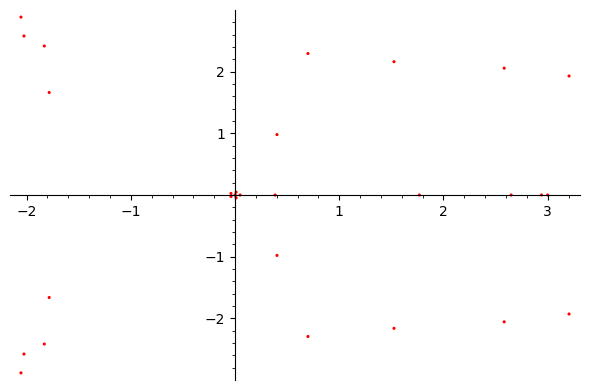

exponent:  5


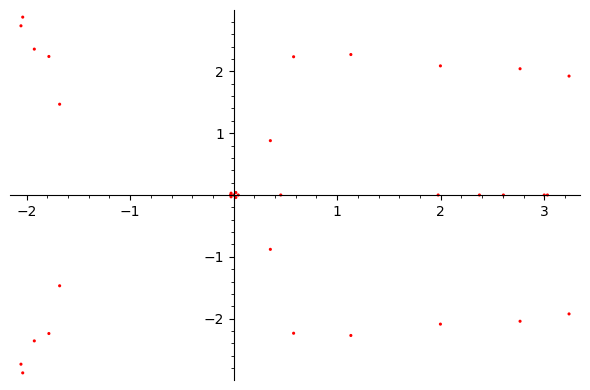

exponent:  6


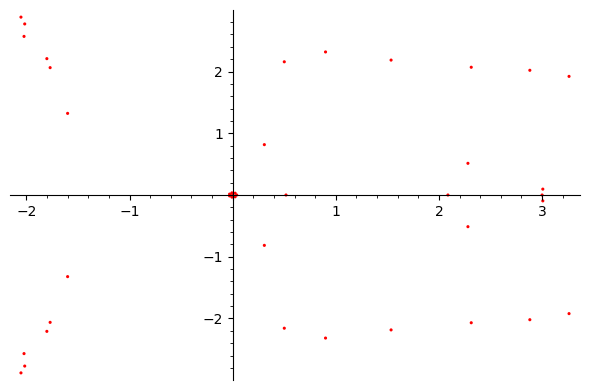

exponent:  7


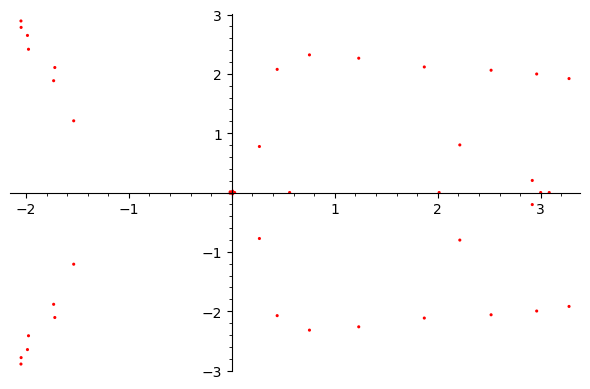

exponent:  8


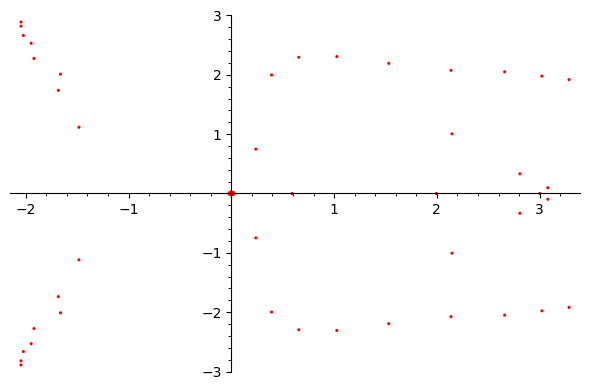

exponent:  9


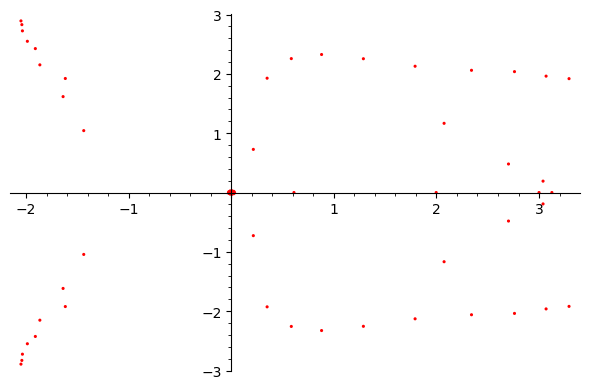

exponent:  10


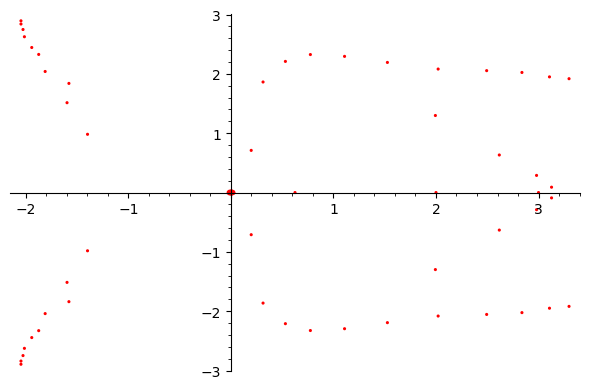

exponent:  11


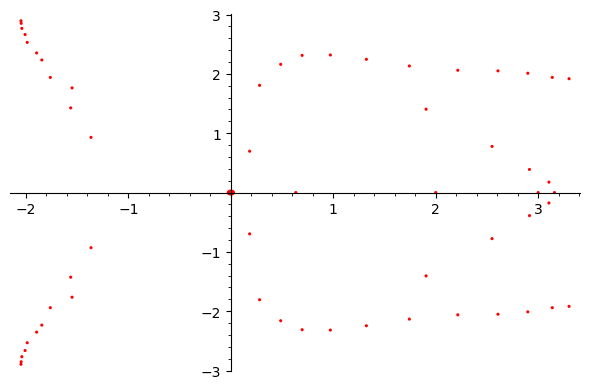

exponent:  12


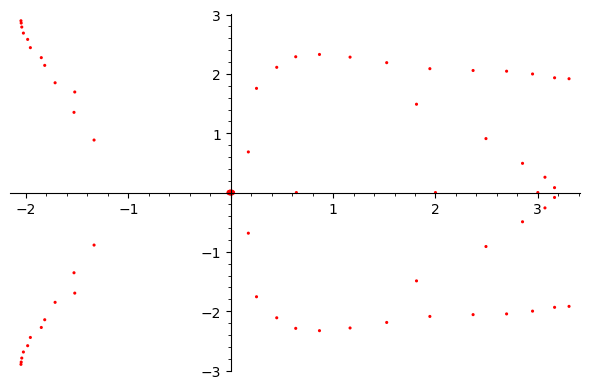

exponent:  13


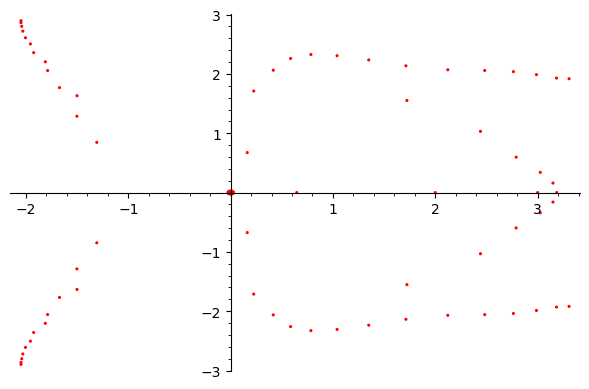

exponent:  14


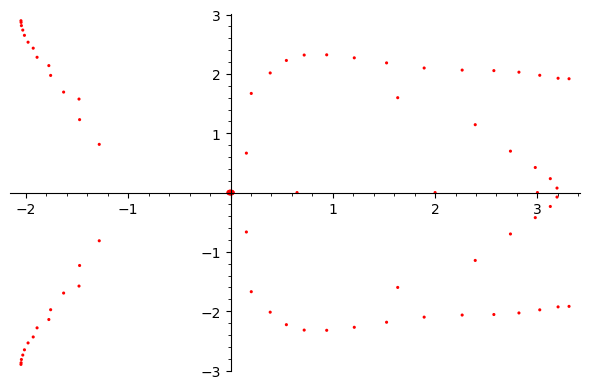

exponent:  15


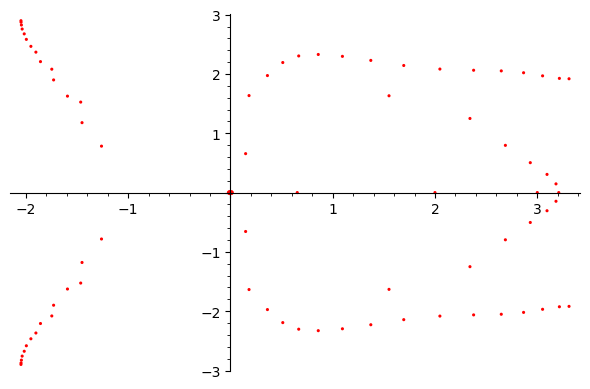

exponent:  16


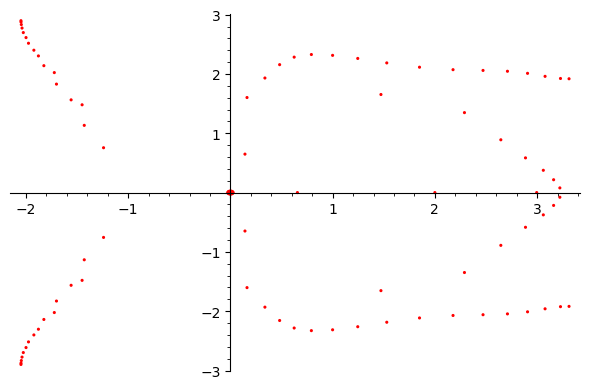

exponent:  17


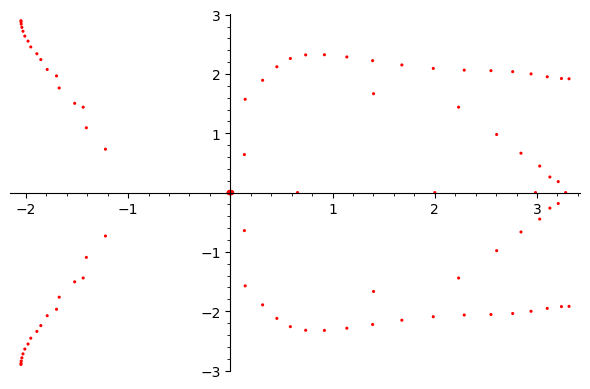

exponent:  18


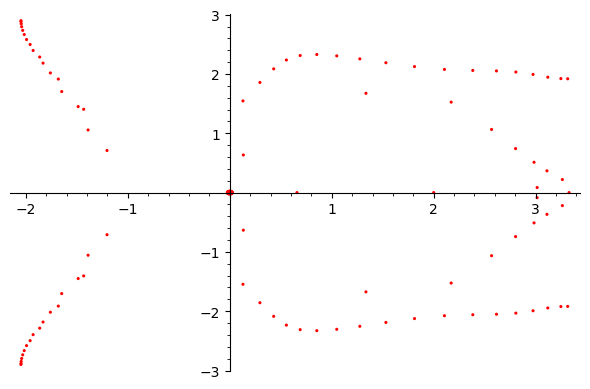

exponent:  19


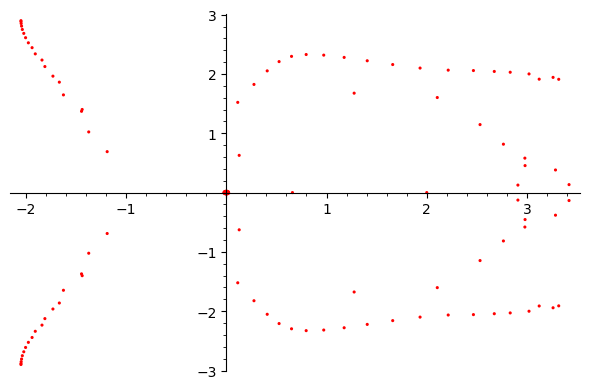

exponent:  20


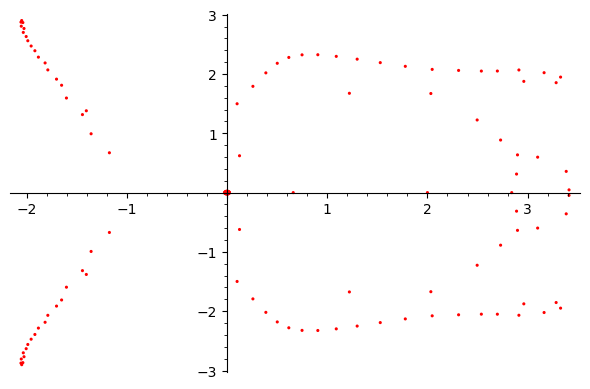

exponent:  21


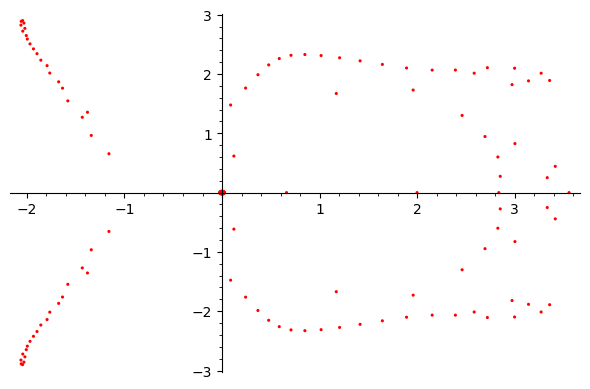

exponent:  22


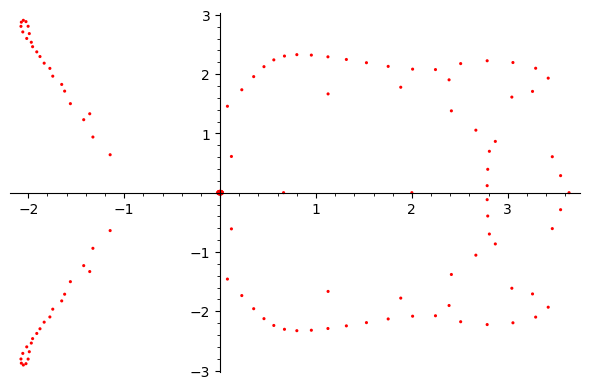

exponent:  23


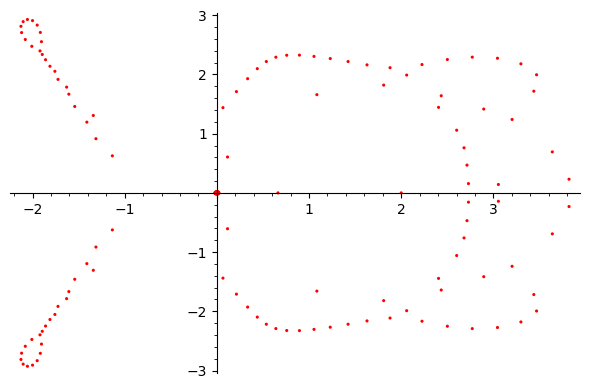

exponent:  24


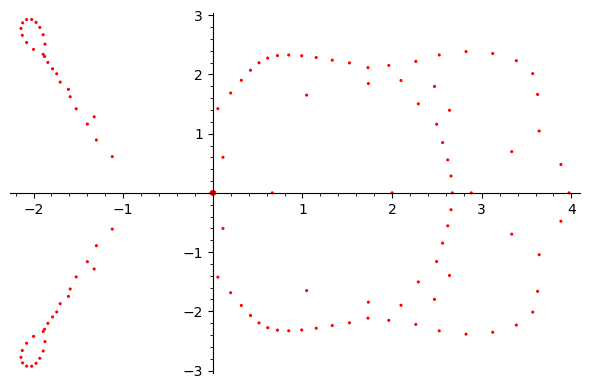

exponent:  25


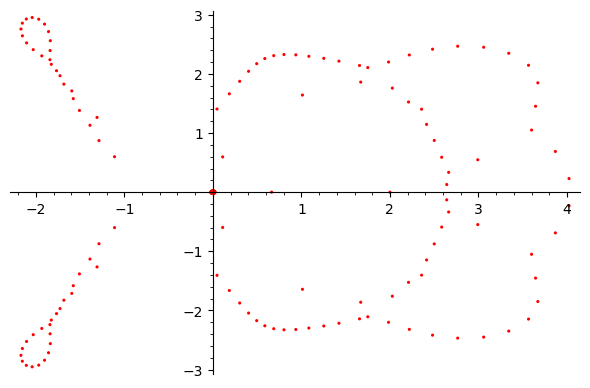

exponent:  26


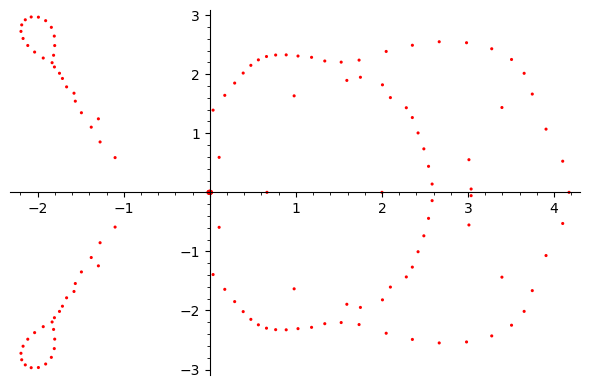

exponent:  27


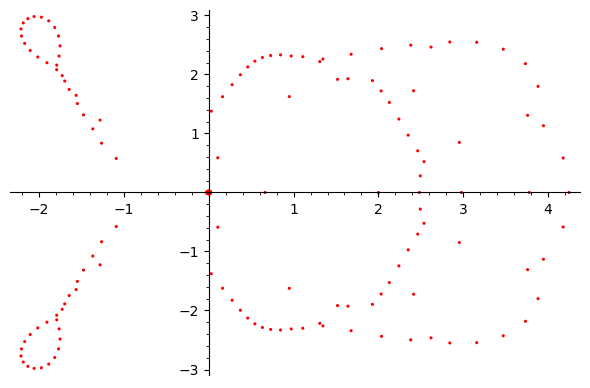

exponent:  28


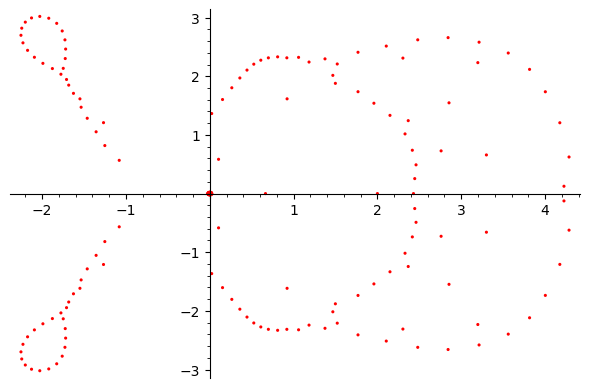

exponent:  29


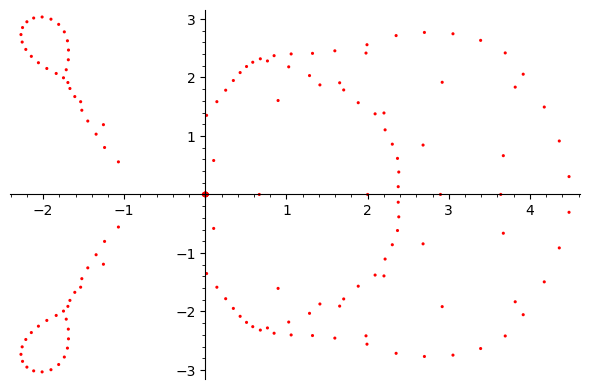

exponent:  30


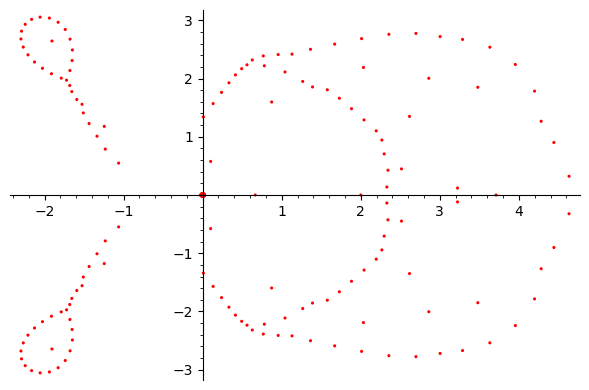

exponent:  31


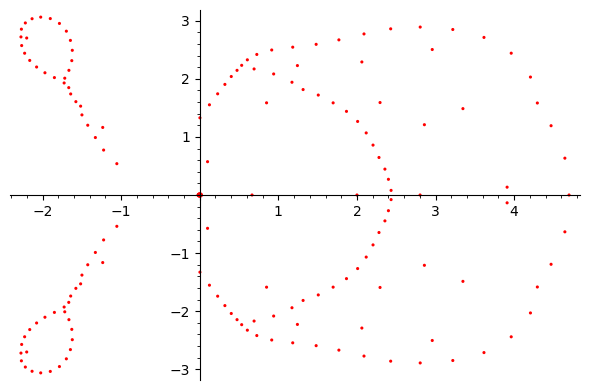

exponent:  32


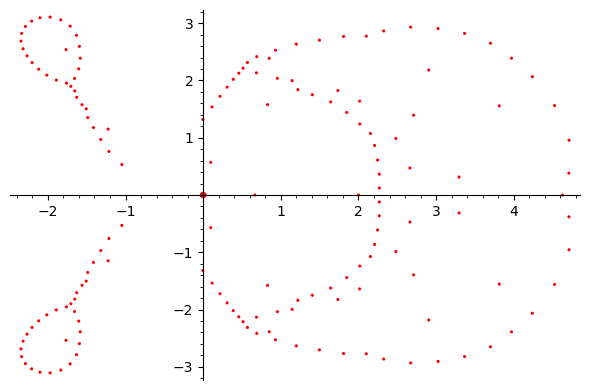

exponent:  33


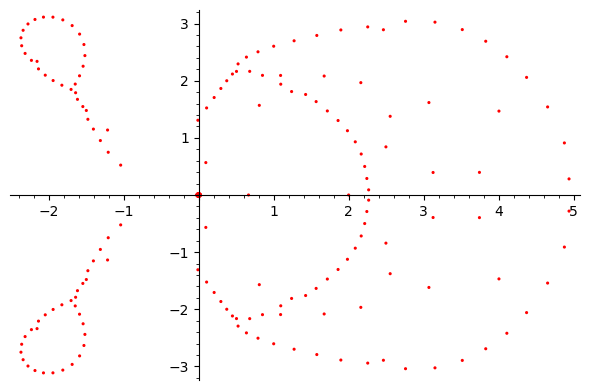

exponent:  34


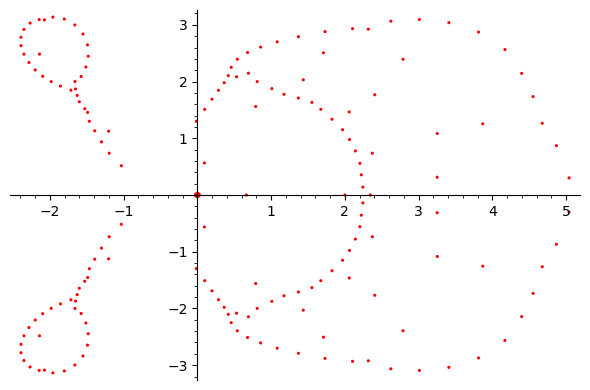

exponent:  35


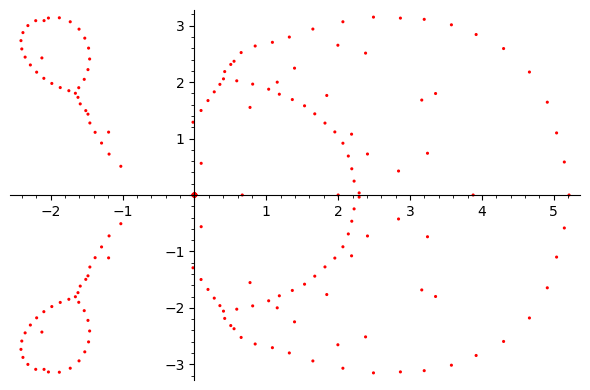

exponent:  36


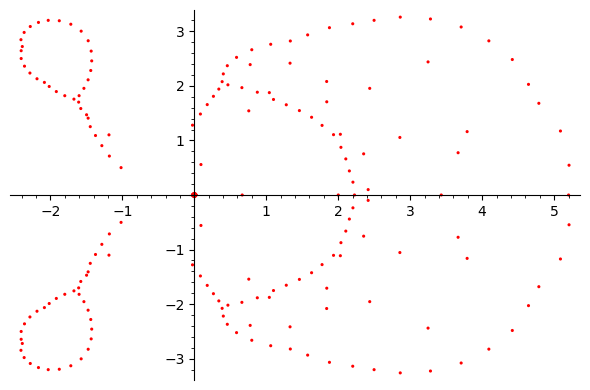

exponent:  37


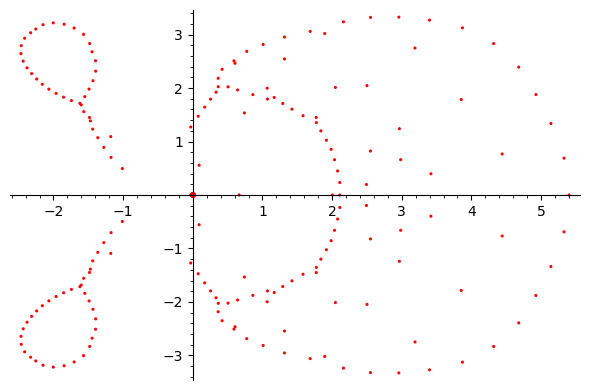

exponent:  38


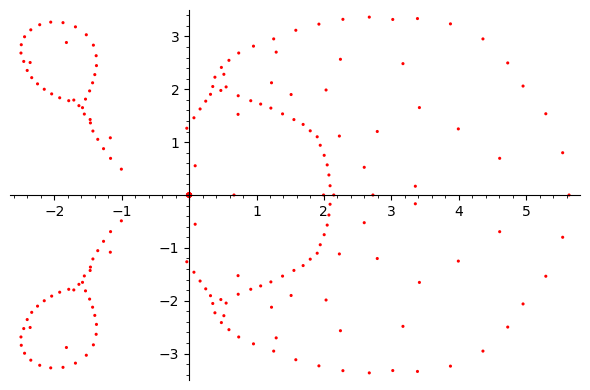

exponent:  39


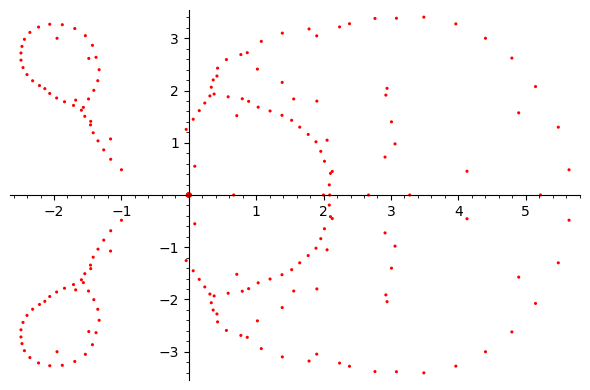

exponent:  40


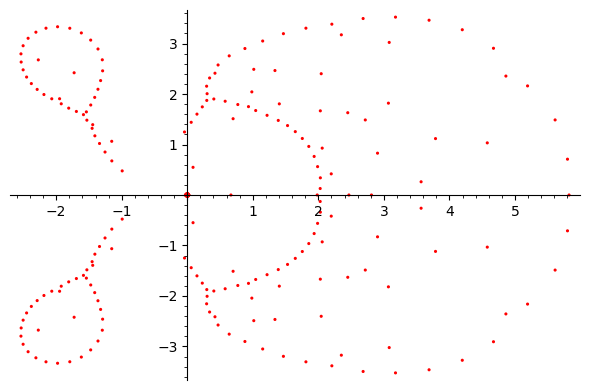

exponent:  41


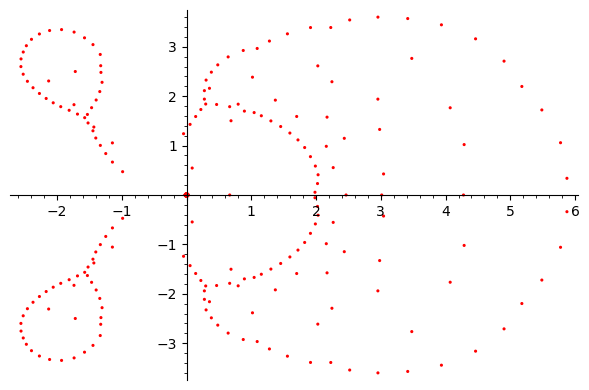

exponent:  42


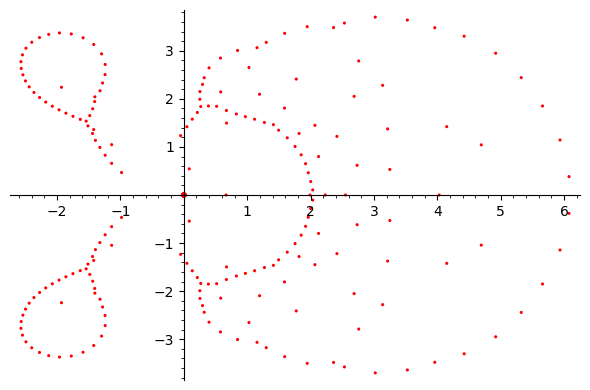

exponent:  43


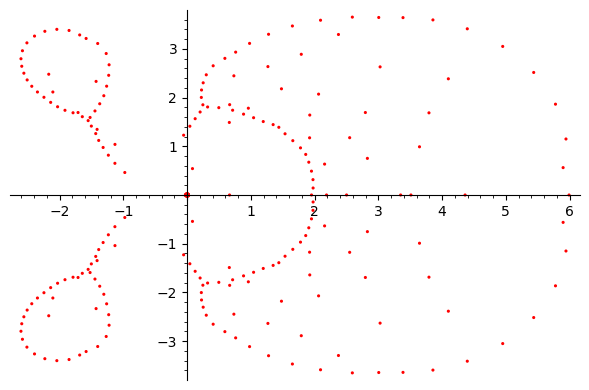

exponent:  44


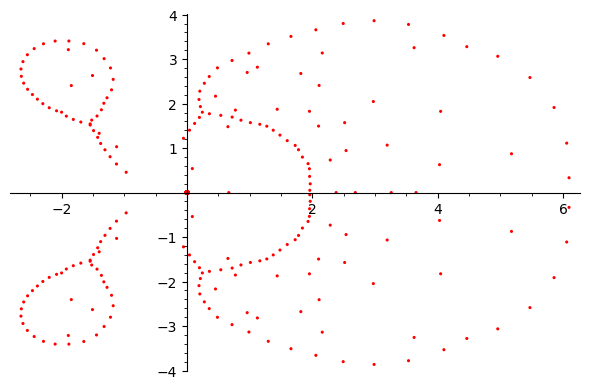

exponent:  45


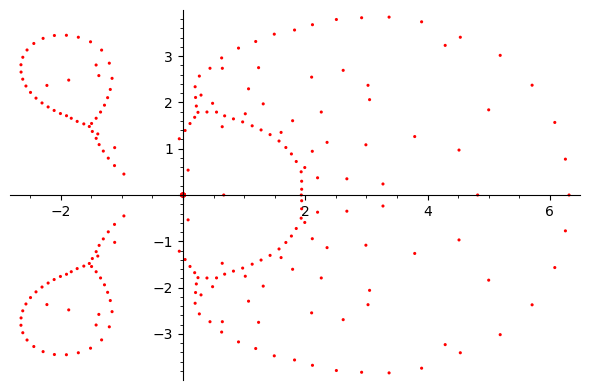

exponent:  46


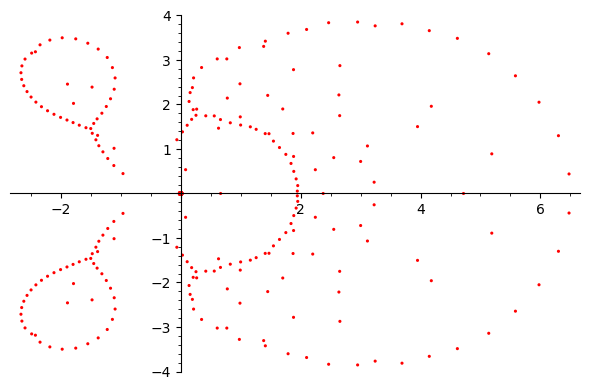

exponent:  47


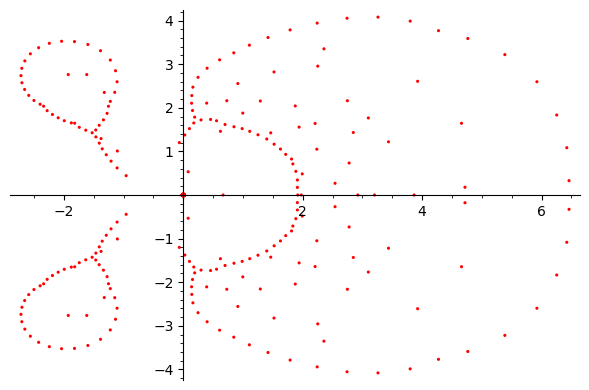

exponent:  48


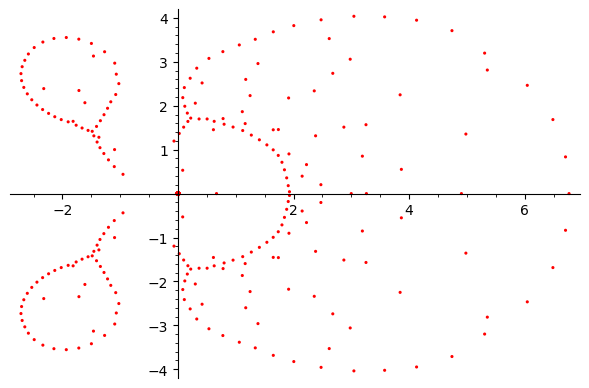

exponent:  49


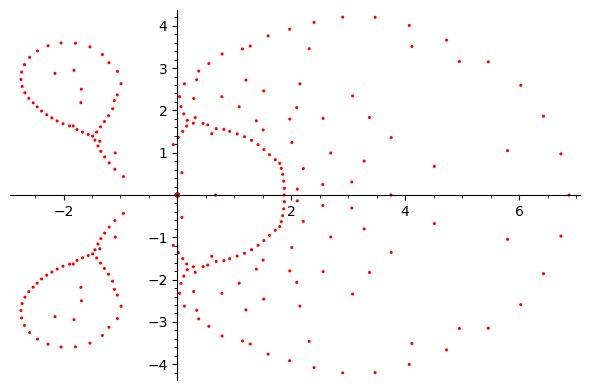

exponent:  50


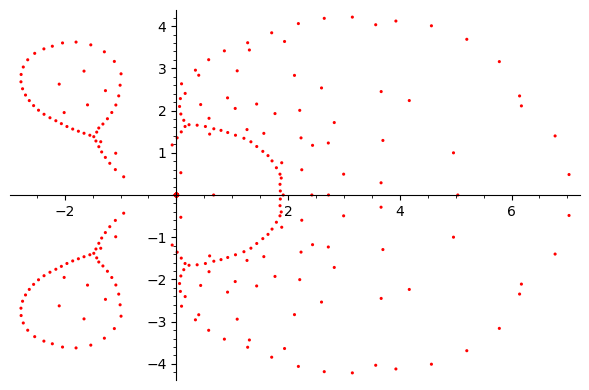

exponent:  51


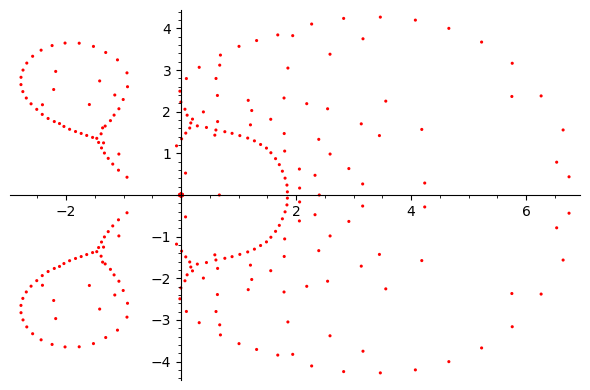

exponent:  52


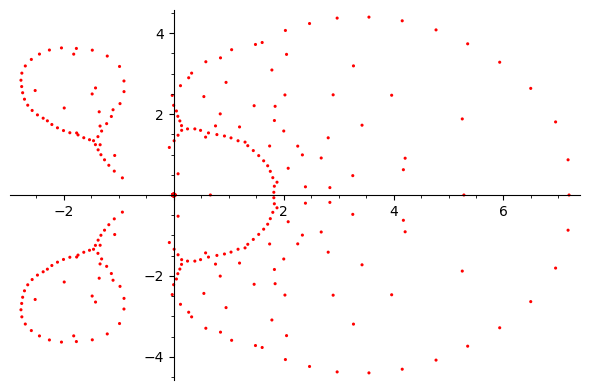

exponent:  53


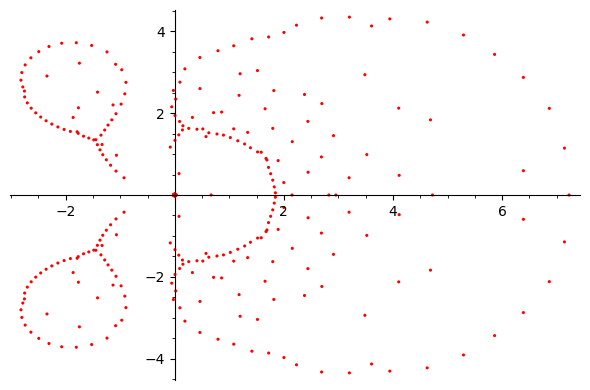

exponent:  54


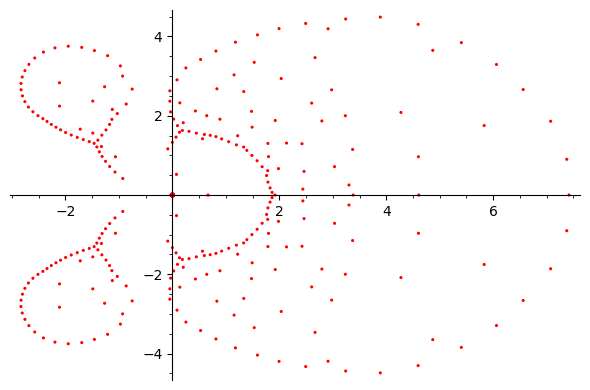

exponent:  55


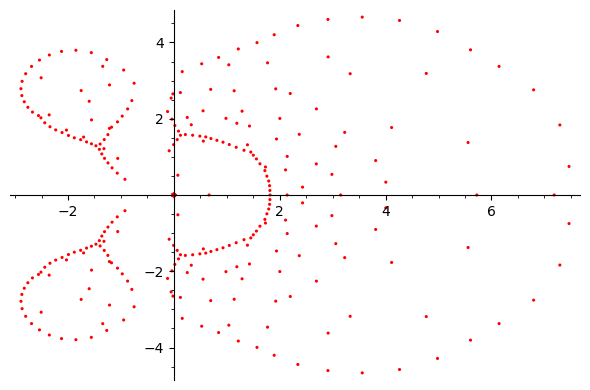

exponent:  56


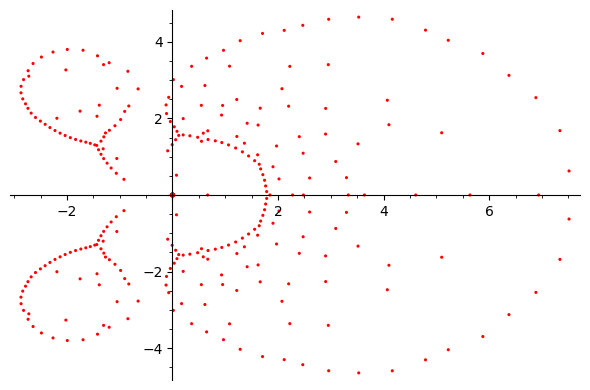

exponent:  57


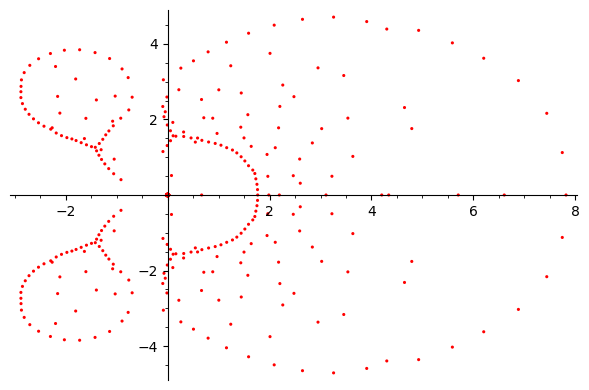

exponent:  58


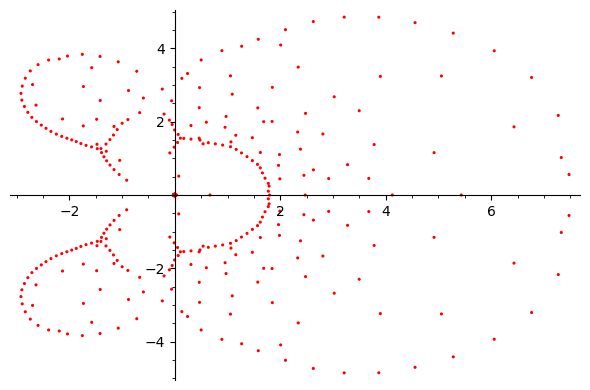

exponent:  59


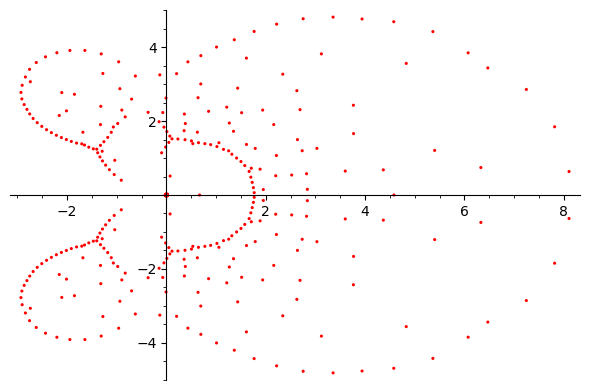

exponent:  60


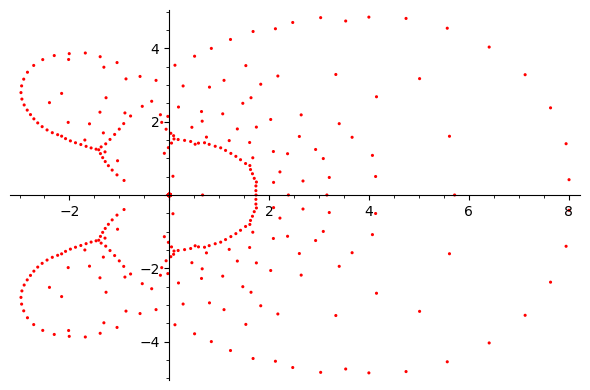

exponent:  61


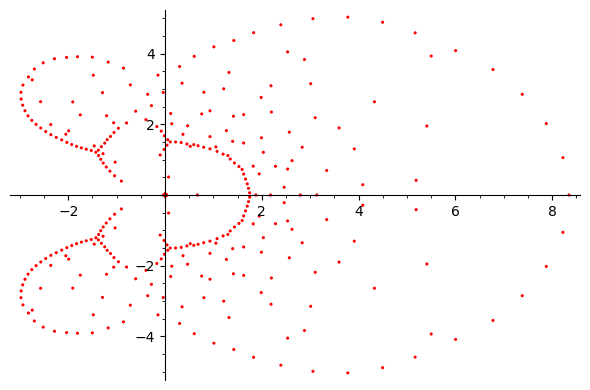

exponent:  62


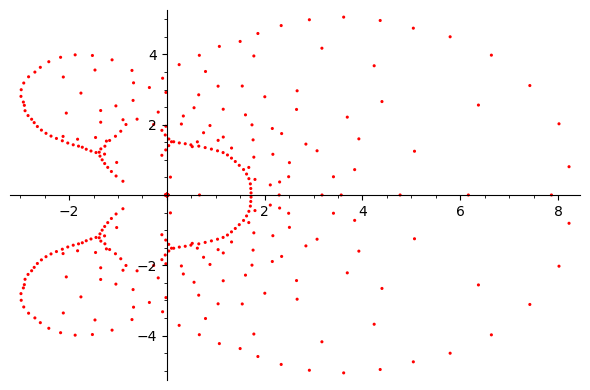

exponent:  63


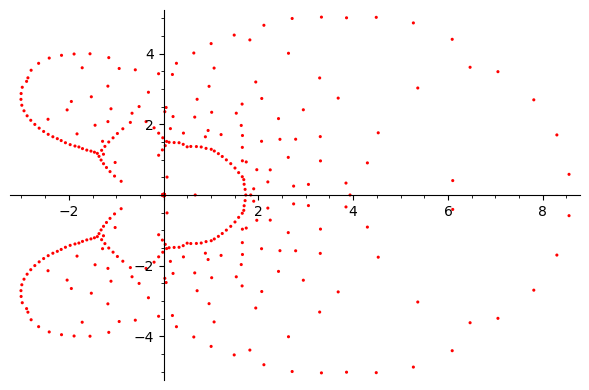

exponent:  64


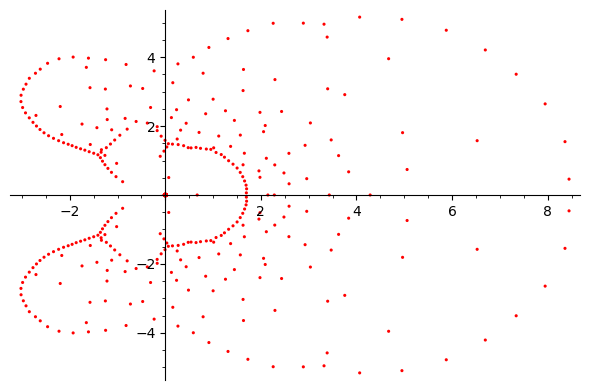

exponent:  65


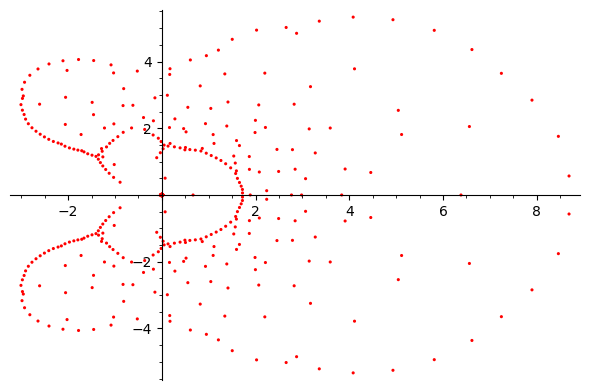

exponent:  66


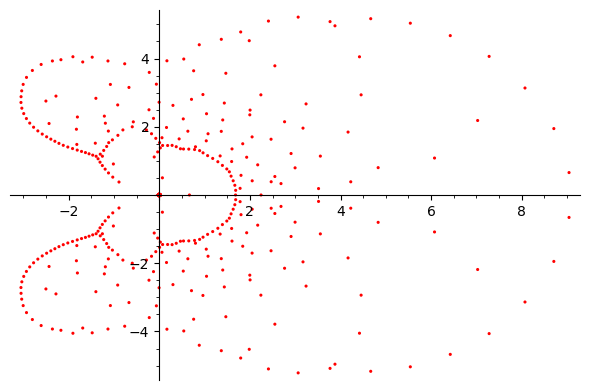

exponent:  67


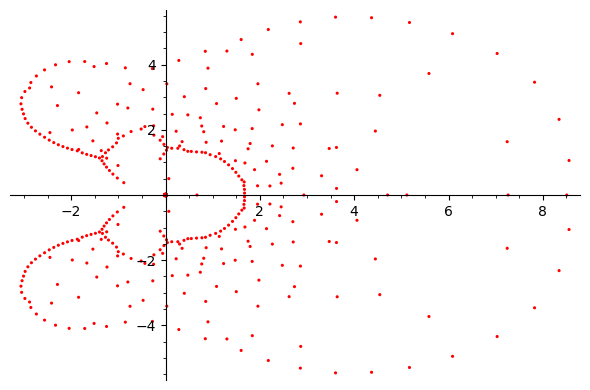

exponent:  68


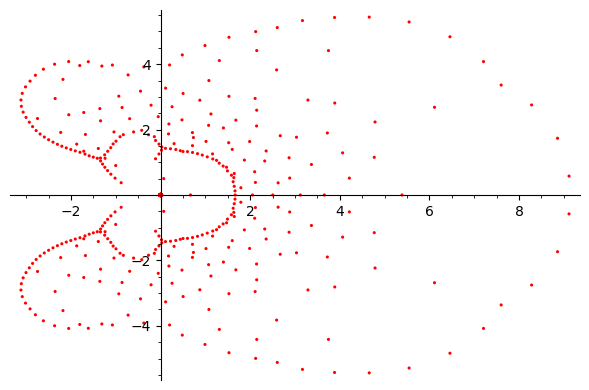

exponent:  69


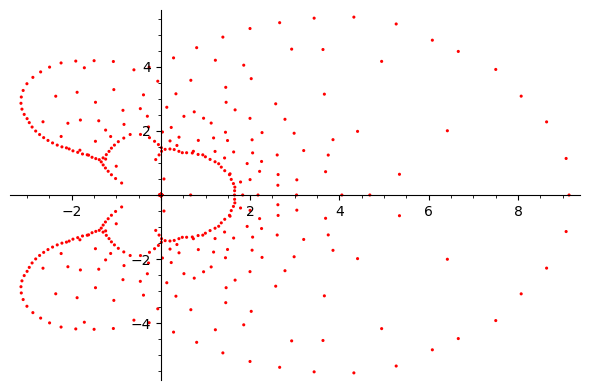

exponent:  70


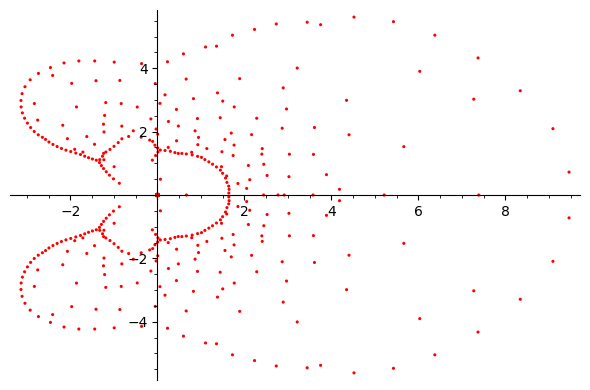

exponent:  71


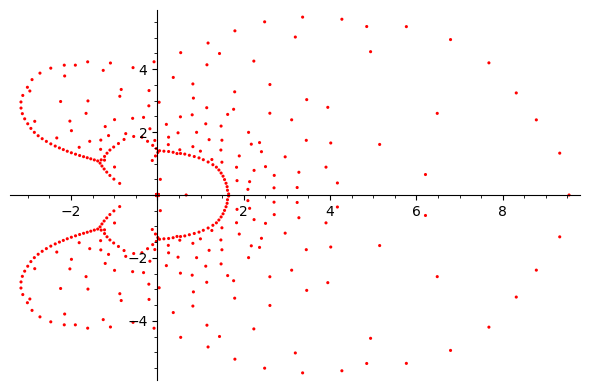

exponent:  72


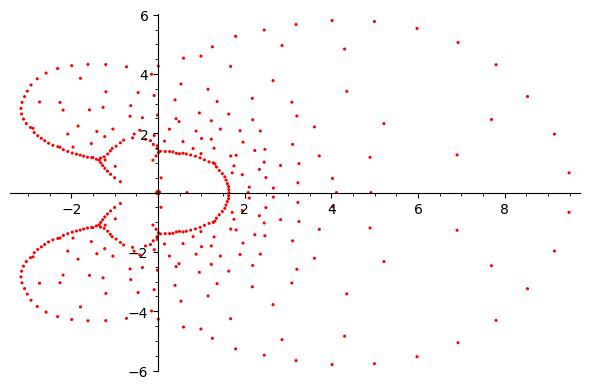

exponent:  73


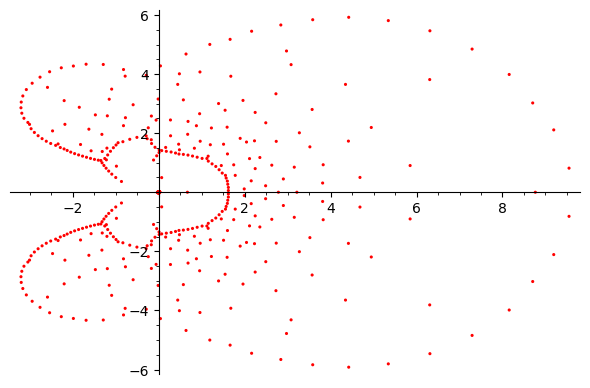

exponent:  74


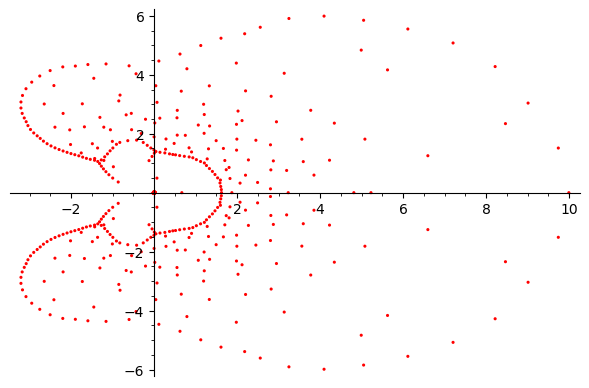

exponent:  75


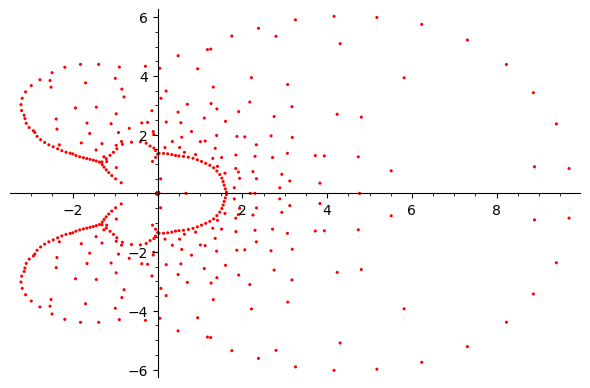

exponent:  76


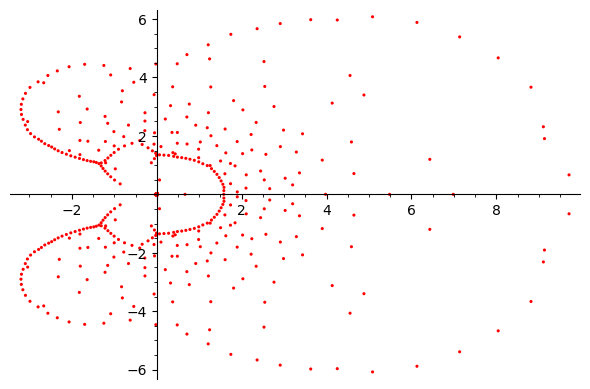

exponent:  77


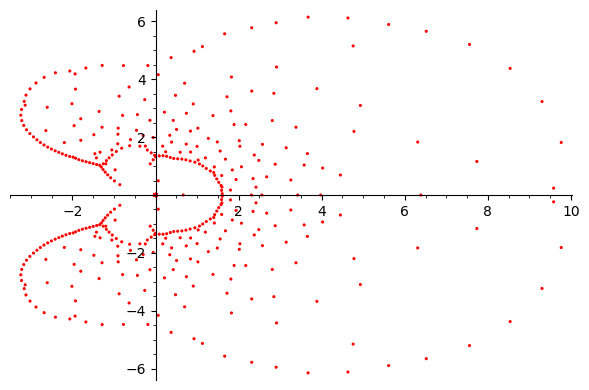

exponent:  78


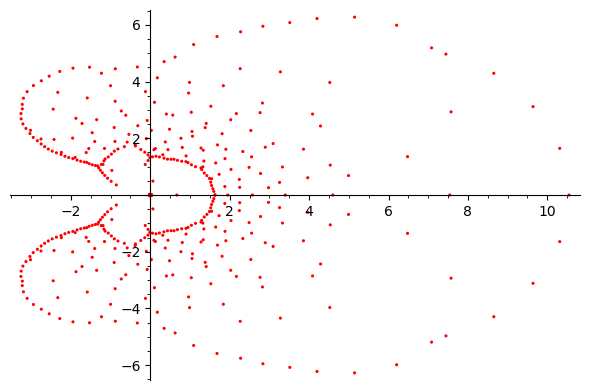

exponent:  79


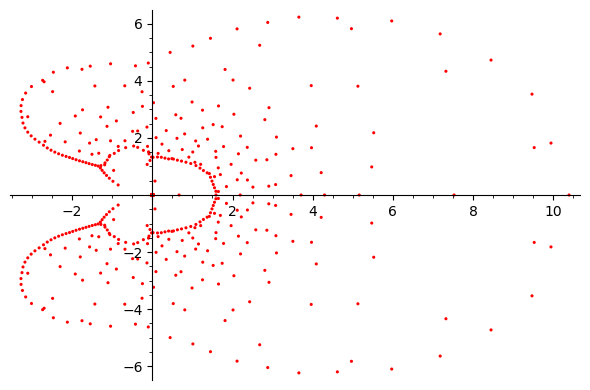

exponent:  80


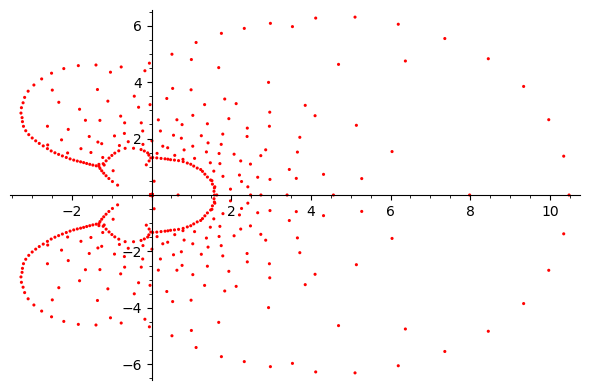

exponent:  81


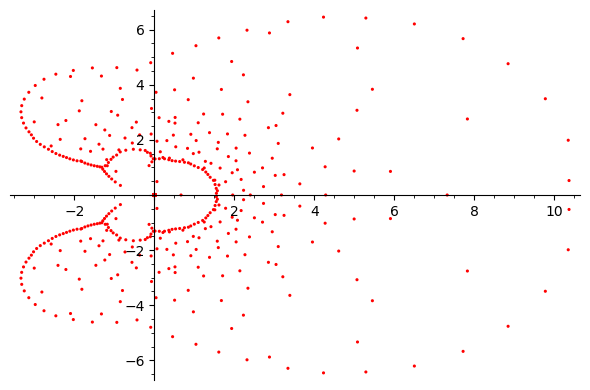

exponent:  82


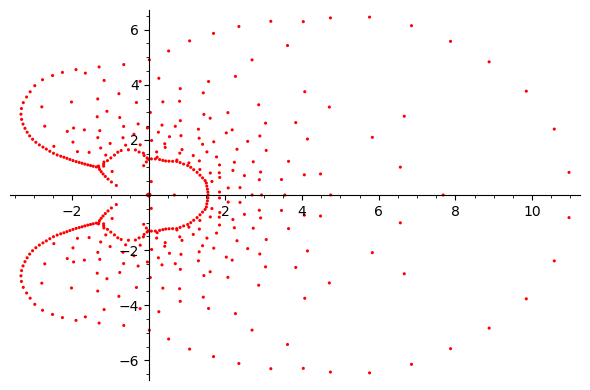

exponent:  83


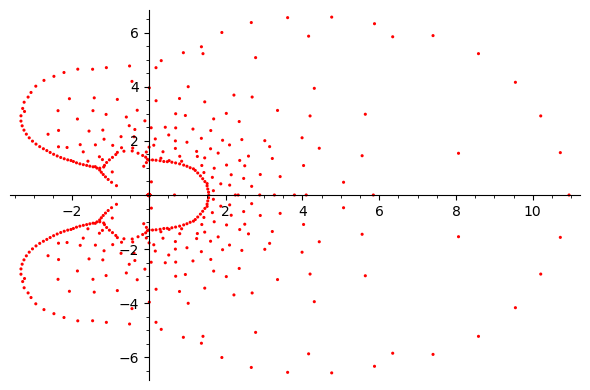

exponent:  84


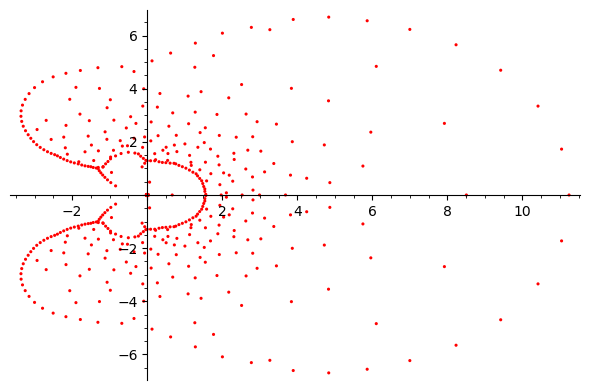

exponent:  85


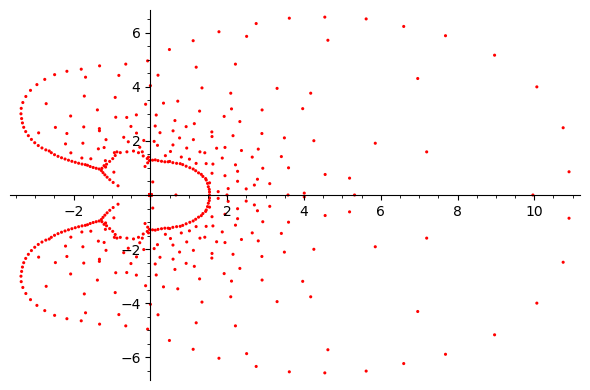

exponent:  86


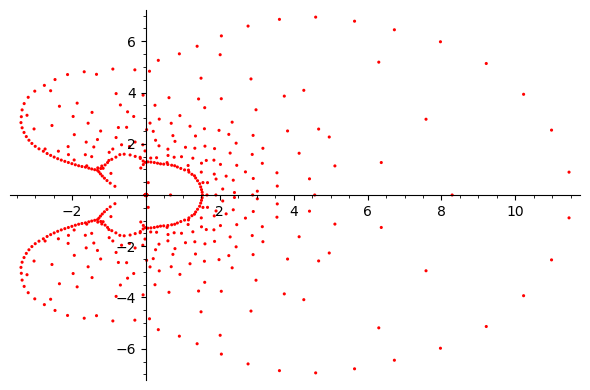

exponent:  87


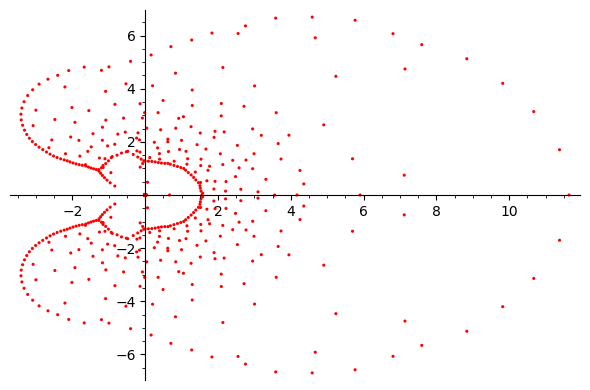

exponent:  88


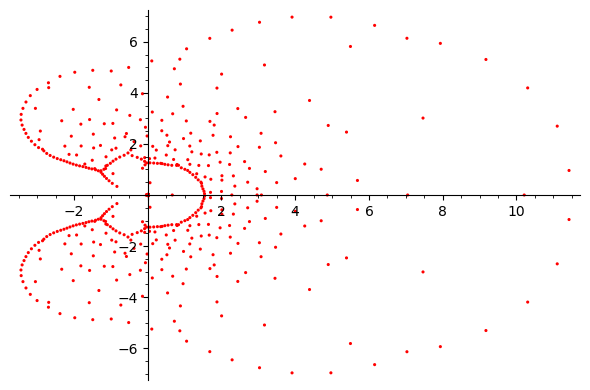

exponent:  89


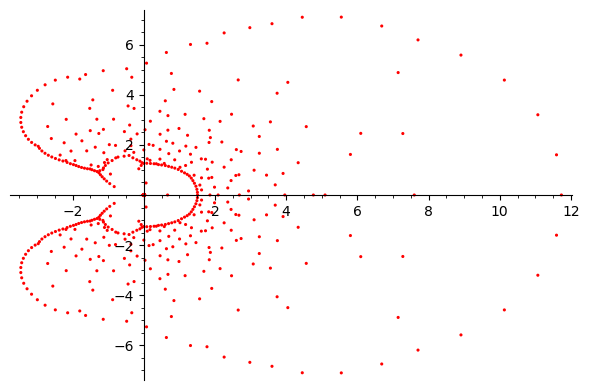

exponent:  90


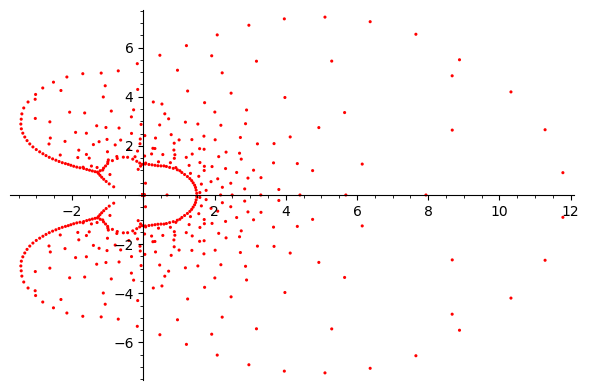

exponent:  91


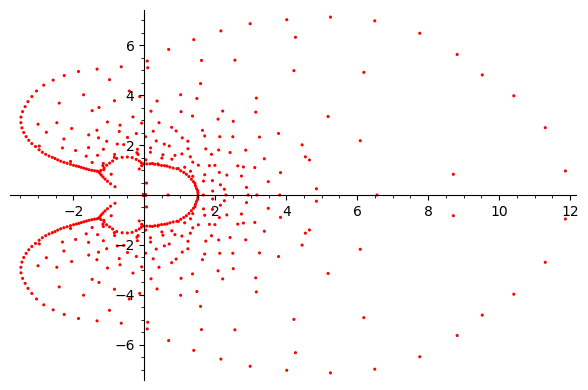

exponent:  92


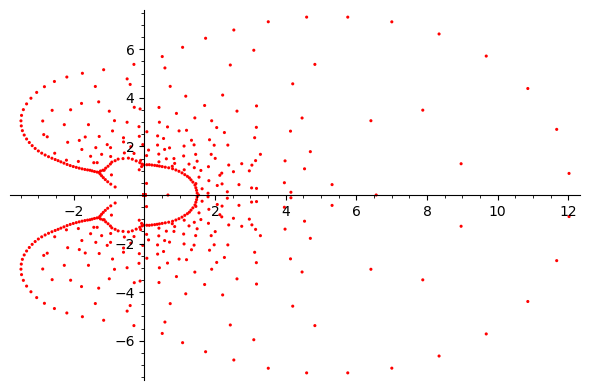

exponent:  93


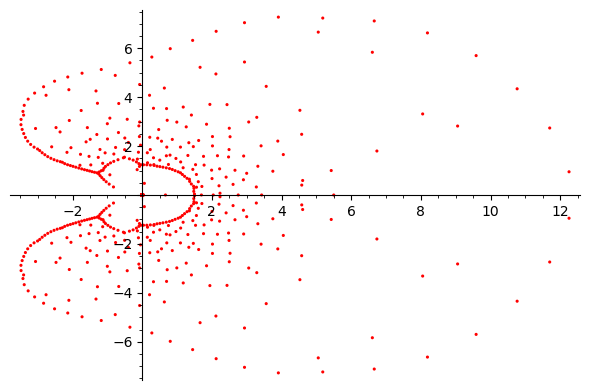

exponent:  94


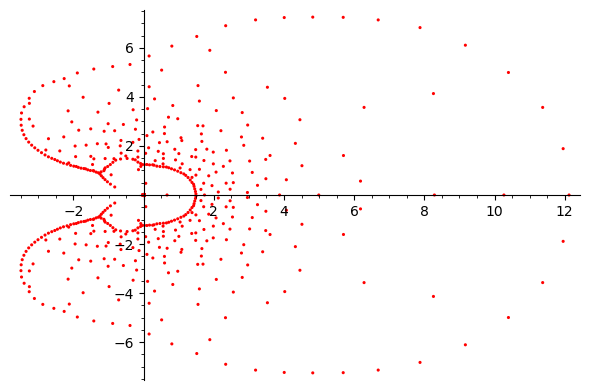

exponent:  95


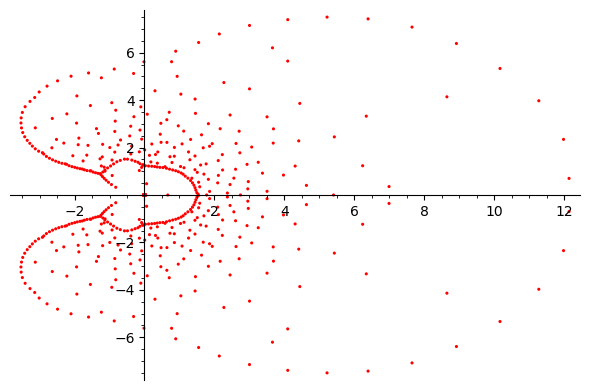

exponent:  96


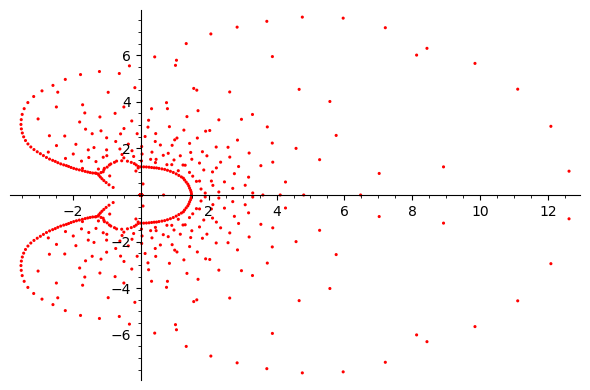

exponent:  97


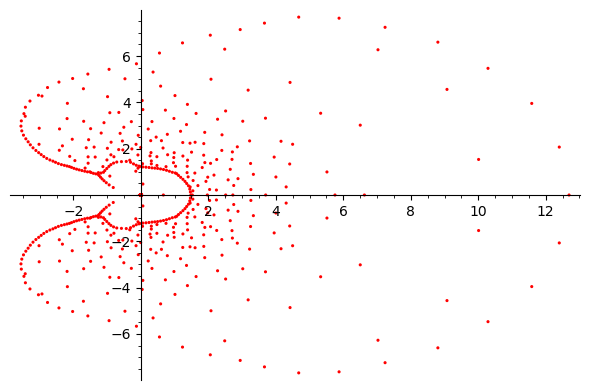

exponent:  98


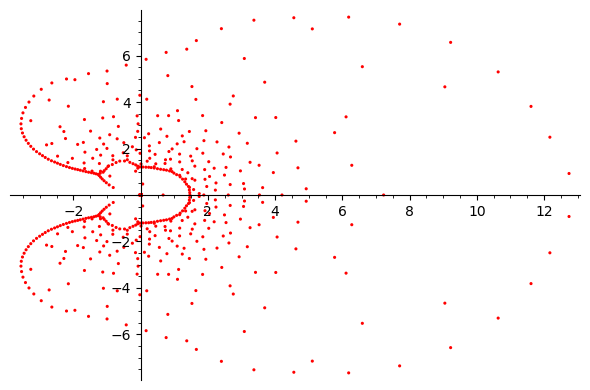

In [ ]:
import pickle
rfile = open('/Users/barrybrent/9sept22no4.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
threeD=[]
allroots=[]
for k in [0..99]:
    print("=====================================================================================")
    exponent=s[k][0]
    print("exponent: ",exponent)
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        if (rootpair in allroots)==False: #otherwise the routine throws an error
            root_triple=(rlroot,imroot,12*exponent/99)
            threeD=threeD+[root_triple]
        roots=roots+[rootpair]
        allroots=allroots+[rootpair]
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)
pd=list_plot3d(threeD)
import pickle
rfile = open('/Users/barrybrent/9sept22no4.txt','rb') #dagger Euler exponents polynomials
rs=pickle.load(rfile)
rfile.close()
s=stripQuotationMarks(rs)
threeD=[]
allroots=[]
for k in [0..99]:
    print("=====================================================================================")
    exponent=s[k][0]
    print("exponent: ",exponent)
    points=[]
    poly=s[k][1]
    poly=R(poly)
    pr=poly.roots(CC)
    lpr=len(pr)
    roots=[]
    for j in [0..lpr-1]:
        root=pr[j][0]
        imroot=imaginary(root)
        rlroot=real(root)
        rootpair=(rlroot,imroot)
        if (rootpair in allroots)==False: #otherwise the routine throws an error
            root_triple=(rlroot,imroot,exponent)
            threeD=threeD+[root_triple]
        roots=roots+[rootpair]
        allroots=allroots+[rootpair]
    rootplot=list_plot(roots,color='red',size=5)
    show(rootplot)
pd=list_plot3d(threeD)
pd.show()